# Aggregating Slice Results: Part 1

In this report, I will explore different ways of aggregating slice classification results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook already uses the optimization methods tested in `4.1 - pureVsConservative`:

 - resize before augmentations 
 - pure lowest validation loss value model choice

In [1]:
# ------------ Utils ------------

from aggregateUtils import * 

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [3]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')

In [4]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## <span style= "color:red"> WARNING </span>

This `FibrosisDataset` class differs from the previous implementations, as it is used in slice aggregation classification, through initialization and return of the `patient_id` variable.

In [5]:
def getPatientID(s):
    # HRCT_Pilot__PatientID
    match = re.search(r'HRCT_Pilot__(\d+)__', s)
    if match: return match.group(1)
        
    # PatientID__sliceSpecific
    match = re.match(r'(\d+)__', s)
    if match:
        return match.group(1)
    return None  

In [6]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)

        return image, label, patient_id

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

## Training

In [7]:
def trainResNet(train_dataset, val_dataset, num_epochs=90, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels, patient_id in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels, patient_id in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return best_model_pure, epoch_pure, loss_array, val_loss_array

In [8]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 1406: 92__CT-1298-0011.npy
(224, 224, 3)


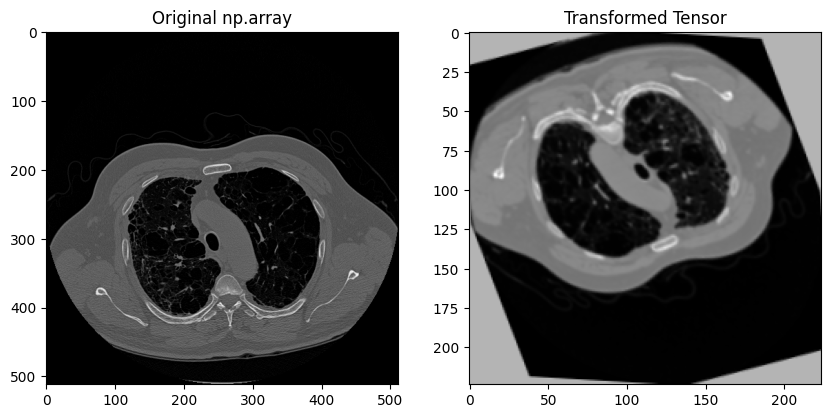

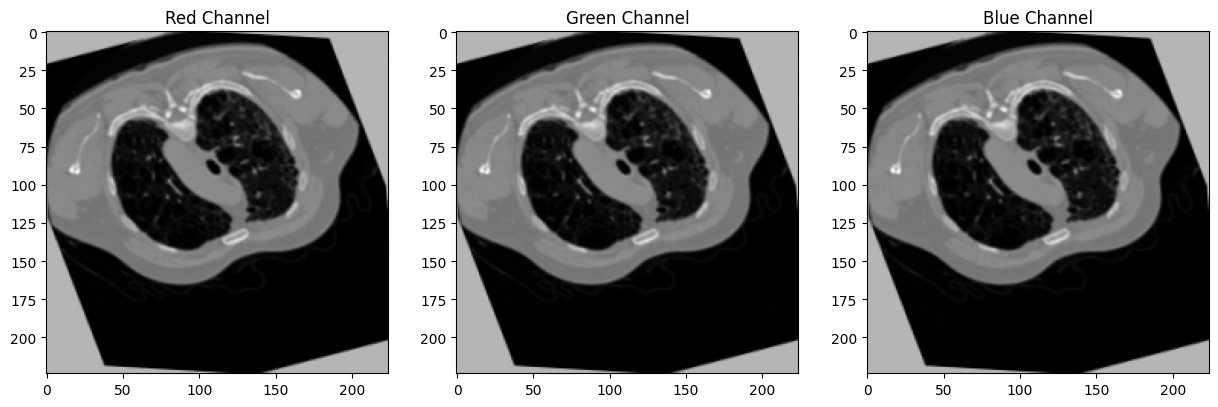

In [9]:
tensorVSnp(train_dataset, df_fibrosis)

In [10]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    """
    # Setup ResNet for Reading
    resnet_eval = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    

    # Use only 2 output neurons
    num_ftrs = resnet_eval.fc.in_features
    resnet_eval.fc = nn.Linear(num_ftrs, 2)

    # Load weights
    resnet_eval.load_state_dict(checkpoint['model_state_dict'])

    """

    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_30320\74141288.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata.pt

In [11]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_aggregate_correct_val.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


# Results and Aggregation Methods

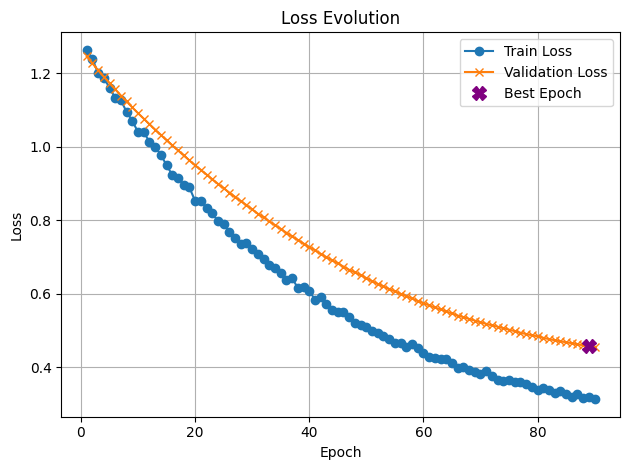

Best Validation Loss:  0.45610323412851855


In [12]:
plotLoss(custom_loss, custom_val_loss, best_epoch)
print("Best Validation Loss: ",custom_val_loss[best_epoch])

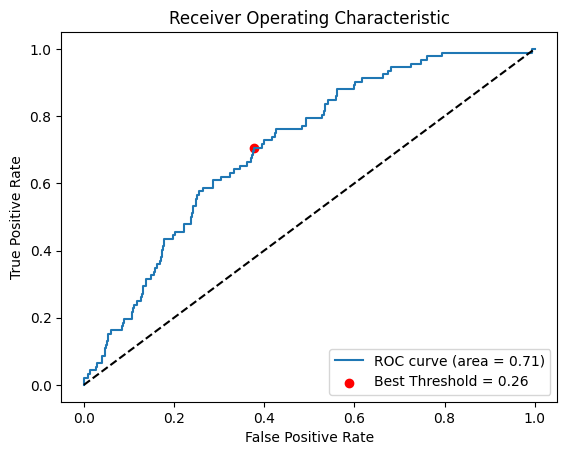

Area Under Curve: 0.7089471793029106
Best Threshold (closest to (0,1)): 0.26189378


In [13]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

In [14]:
def evalResNet(resnet18, test_dataset, threshold):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []

    # for feature based
    #lat=resnet.define_hook(fc)

    with torch.no_grad():
        for images, labels, patient_id in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")


    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [15]:
evalResNet(resnet_eval, test_dataset,threshold_eval)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 50.80%  (286 in 563)
Accuracy for Class 1: 84.71%  (72 in 85)
Test Accuracy: 55.25%
Weighted Accuracy: 80.20%

 --------------------- 

F1 Score (Macro): 0.498
F1 Score (Weighted): 0.620
F1 Score Class 0: 0.664
F1 Score Class 1: 0.332

 --------------------- 


Confusion Matrix: 
 [[286 277]
 [ 13  72]]


## Patient-wise Classification

This will be done through aggregation of the probabilities determined by the resnet for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of probabilities. 
 - another dictionary containing the same keys, but with binary classification value arrays.

### <span style = "color:red"> WARNING  </span>

It's also important to re-define the best threshold, as the one obtained above was meant for slice-level classification. Aditionally, a new, individual best threshold must be determined for each aggregation criteria.

However, this introduces a challenge in implementation. In order to find the best threshold for the "majority_vote" and "n_is_enough" methods, **I already need a threshold prior to finding the best AUC-ROC**. This is recursive-variable-dependecy problem.

#### How can I mitigate this issue?

 - Instead of finding an optimal threshold, I will **choose the classification with the highest likelyhood/probability, as per determined by the model**.
 - **Performing a sweep** of best thresholds based on the **best mean threshold**.

After discussing with supervisors, the first option was chosen as the best candidate.

In [16]:
def getMaxSliceNumber(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    patient_prob = {}
    for images, labels, patient_id in loader:
        images, labels = images.to(device), labels.to(device)

        for pid, slice, label in zip(patient_id, images.tolist(), labels.tolist()):
                # Initializes key:value pair if it doesn't exist
                if pid not in patient_prob: patient_prob[pid] = 1  
                patient_prob[pid] += 1

    return max(patient_prob.values())

In [17]:
def getROCAggregate(model, dataset, threshold, aggregate_criteria="mean", show_plot=True): 

    all_labels, all_scores = [], []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    model.eval()
    with torch.no_grad():
        for images, labels, patient_id in loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = model(images)

            # Translate logits to probabilities using softmax
            # and then chooses only values for Class 1 (0 or 1)
            probs = F.softmax(outputs, dim=1)[:, 1] 
        
            # Associate probabilities/values to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Sets classification as 0 until otherwise

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 # Updates Classification
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            final_prob = np.mean(prob_list)
        
        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            final_prob = (ctr1/(ctr1+ctr0)) if aggregate_criteria == "ratio" else ctr1

        label = patient_class[id]

        #  y_true, y_pred -> all_scores, all_labels
        all_labels.append(label)
        all_scores.append(final_prob)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    if show_plot:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold for method {aggregate_criteria} = {best_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print("Area Under Curve:", roc_auc)
        print("Best Threshold (closest to (0,1)):", best_threshold)

    return best_threshold, roc_auc

### Getting Test Threshold: `mean`

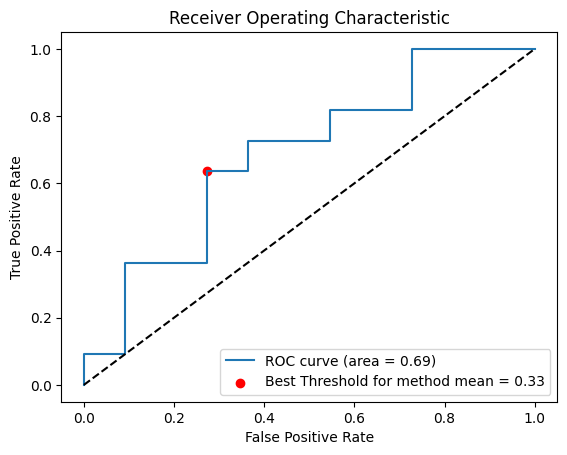

Area Under Curve: 0.6859504132231404
Best Threshold (closest to (0,1)): 0.32591142734655965


In [18]:
mean_thresh, mean_roc_auc = getROCAggregate(resnet_eval, val_dataset, threshold_eval, aggregate_criteria="mean")

### Getting Test Threshold: `ratio`

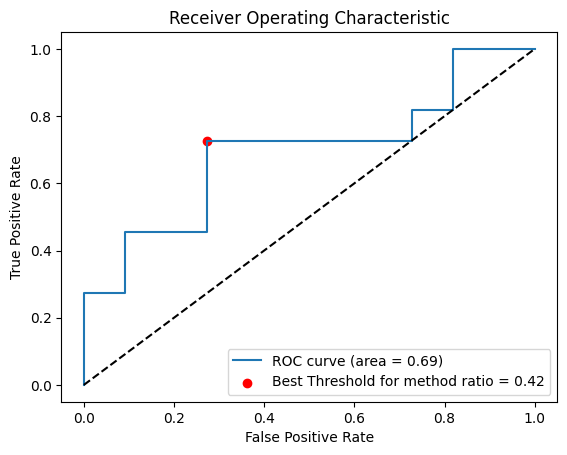

Area Under Curve: 0.6942148760330579
Best Threshold (closest to (0,1)): 0.4166666666666667


In [19]:
rat_thresh, rat_roc_auc = getROCAggregate(resnet_eval, val_dataset, threshold_eval, aggregate_criteria="ratio")

### Getting Test Threshold: `n_is_enough`

The threshold for this method corresponds to the optimal number of slices.

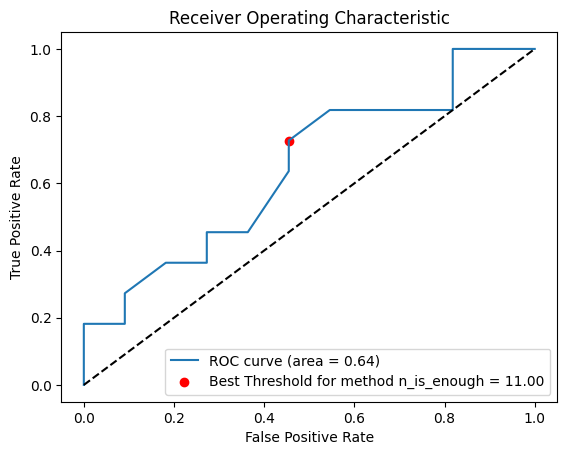

Area Under Curve: 0.6446280991735538
Best Threshold (closest to (0,1)): 11.0


In [20]:
n_thresh, n_roc_auc = getROCAggregate(resnet_eval, val_dataset, threshold_eval, aggregate_criteria="n_is_enough")

# Testing Aggregation Methods

In [21]:
def evalPatientProbResNet(resnet18, test_dataset, threshold, aggregate_criteria="mean", n=1, ratio= 0.5, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    # Used to store values after aggregation
    patient_aggregate = {}


    # 1. This loop populates dictionaries with values pulled from the model
    with torch.no_grad():
        for images, labels, patient_id in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Associate probabilities to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Same principle

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 
                       
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            prob = np.mean(prob_list)
            patient_aggregate[id] = prob

            # If larger -> True -> int -> 1
            # If smaller -> False -> int -> 0
            predicted = int(prob >= threshold)

        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            # If ratio of slices == 1 is >= threshold_ratio 
            # OR if number of slices >= threshold_n 
            # THEN patient_classification == 1
            # 0 otherwise
            predicted = int((ctr1/(ctr1+ctr0)) >= ratio) if aggregate_criteria == "ratio" else int(ctr1>=n)

        label = patient_class[id]

        # Counters for metrics   
        total += 1
        if patient_class[id] == 0:
            total_class_0 += 1
            if predicted == patient_class[id]:
                correct_class_0 += 1
                correct += 1
        elif patient_class[id] == 1:
            total_class_1 += 1
            if predicted == patient_class[id]:
                correct_class_1 += 1
                correct += 1

        # Populate y_true and y_pred lists for F1 Score
        # print(id, patient_class[id])
        y_true.append(patient_class[id])
        y_pred.append(predicted)
        

    
    # Weights change here -> Class == 1 is the majority class
    weight_0, weight_1 = 14/24, 10/24

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    if correct_class_0 == total_class_0: accuracy_class_0 = 100

    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    if correct_class_1 == total_class_1: accuracy_class_1 = 100

    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    print("Labels:    ",y_true)
    print("Predicted: ", y_pred)
    # print(type(y_true), type(y_pred))


    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    if verbose:

        # Accuracy
        print("\n --------------------- \n")
        print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
        print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
        print(f"Test Accuracy: {accuracy:.2f}%")
        if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
        print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

        # F1 scores
        print("\n --------------------- \n")
        print(f"F1 Score (Macro): {f1_macro:.3f}")
        print(f"F1 Score (Weighted): {f1_weighted:.3f}")
        print(f"F1 Score Class 0: {f1_class_0:.3f}")
        print(f"F1 Score Class 1: {f1_class_1:.3f}")

        # Confusion matrix
        print("\n --------------------- \n")
        print("\nConfusion Matrix: \n", conf_mat)    

## Mean

In [22]:
evalPatientProbResNet(resnet_eval, test_dataset, mean_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 71.43%  (10 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 70.60%

 --------------------- 

F1 Score (Macro): 0.704
F1 Score (Weighted): 0.710
F1 Score Class 0: 0.667
F1 Score Class 1: 0.741

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 4 10]]


The threshold defined for slice-based prediction optimization does not work well with the mean of all slice probabilities. Some probability values are much different then others, which prompted the mean to always be larger than the threshold, resulting in prediction of Class == 1 in 100% of the cases.

## N is enough

Aggregation technique with a customizable threshold for number of Class == 1 slices needed to consider fibrosis present in a patient.

After testing with absolute values, and taking into account that different patients will most likely have a different number of slices, I decided to implement both absolute and relative conditions:

 - if n is an integer **(absolute)**: if a patient displays at least n slices with Class == 1, then the patient is classified as Class == 1.
 - if n is a float **(ratio)**: if a patient displays at least n% slices with Class == 1, then the patient is classified as Class == 1.

### Absolute Value Tests 

#### Using `n_thresh`

In [23]:
evalPatientProbResNet(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="n_is_enough", n=n_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 79.17%
Weighted Accuracy: 76.55%

 --------------------- 

F1 Score (Macro): 0.782
F1 Score (Weighted): 0.790
F1 Score Class 0: 0.737
F1 Score Class 1: 0.828

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 2 12]]


### Relative Value Tests

In [29]:
evalPatientProbResNet(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="ratio", ratio=rat_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 92.86%  (13 in 14)
Test Accuracy: 83.33%
Weighted Accuracy: 79.52%

 --------------------- 

F1 Score (Macro): 0.822
F1 Score (Weighted): 0.830
F1 Score Class 0: 0.778
F1 Score Class 1: 0.867

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 1 13]]
